In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.constants import c

from scipy.optimize import curve_fit
from datetime import datetime

#%matplotlib qt

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
f_carrier = 2216499175.240134 #seed value for corrected carrier search

f_carrier_20221119 = 2216499173.4376664  #carried forward from 2022-11-19 Doppler analysis of centre carrier.

lower2_offset = 45454.42960526 # calulated average value of the lower2 carrier offset over previous days.

print(lower2_offset/2)

upper2_offset = -22727.29310345

22727.21480263


In [3]:
data = np.fromfile('/media/scott/fast/data/20221121/full_centre.dat', sep = ' ').reshape((-1,4))
t_data = Time(data[:,0], format = 'mjd')
freq_data = data[:,1]
int_data = data[:,2]

In [4]:
data2 = np.fromfile('/media/scott/fast/data/20221121/full_upper2.dat', sep = ' ').reshape((-1,4))
t_data2 = Time(data2[:,0], format = 'mjd')
freq_data2 = data2[:,1] + upper2_offset 
int_data2 = data2[:,2]

In [5]:
gmd_file = '/home/scott/code/GMAT/R2020a/output/Artemis1_Doppler_postlunar1.gmd'
gmd_mjd = []
gmd_rangerate = []
with open(gmd_file) as f:
    for l in f.readlines()[2:]:
        gmd_mjd.append(float(l.split()[0]))
        gmd_rangerate.append(float(l.split()[-1]))
gmd_mjd = np.array(gmd_mjd)
gmd_rangerate = np.array(gmd_rangerate)
t_gmd = Time(gmd_mjd + (2430000.0 - 2400000.5), scale = 'tai', format = 'mjd')

In [6]:
#Centre
rangerate_interp = np.interp(t_data.utc.mjd, t_gmd.utc.mjd, gmd_rangerate)
freq_gmat = f_carrier * (1 - 1e3*rangerate_interp/c)

#Lower2
rangerate_interp2 = np.interp(t_data2.utc.mjd, t_gmd.utc.mjd, gmd_rangerate)
freq_gmat2 = f_carrier * (1 - 1e3*rangerate_interp2/c)


#Centre residuals
freq_diff = freq_data - freq_gmat
np_diff = np.array(freq_diff)

#Lower2 residuals
freq_diff2 = freq_data2 - freq_gmat2
np_diff2 = np.array(freq_diff2)

In [7]:
#Centre
x = 0
count = t_data.shape[0]
t_zero = (data[0,0] - int(data[0,0])) * 86400
np_t = [0.0] * count

for x in range (0,count):
    np_t[x] = ((data[x,0] - int(data[0,0])) * 86400) - t_zero

np_t = np.array(np_t)

#Lower2
x = 0
count = t_data2.shape[0]
t_zero2 = (data2[0,0] - int(data2[0,0])) * 86400
np_t2 = [0.0] * count

for x in range (0,count):
    np_t2[x] = ((data2[x,0] - int(data2[0,0])) * 86400) - t_zero2

np_t2 = np.array(np_t2)

In [8]:
#Find corrected carrier

#Centre
m, b = np.polyfit(np_t, np_diff,1)
corrected_carrier = f_carrier + np.mean(np_diff)

last_carrier = corrected_carrier

while True:
    freq_gmat = corrected_carrier * (1 - 1e3*rangerate_interp/c)
    freq_diff = freq_data - freq_gmat
    np_diff = np.array(freq_diff)
    m, b = np.polyfit(np_t, np_diff,1)
    corrected_carrier = last_carrier + np.mean(np_diff)
    print(corrected_carrier)
    diff_carrier = last_carrier - corrected_carrier
    print(diff_carrier)
    last_carrier = corrected_carrier
    if diff_carrier < 0:
        diff_carrier = diff_carrier * -1
    if (diff_carrier < 0.000001):
        break
        
#Lower2
m2, b2 = np.polyfit(np_t2, np_diff2,1)
corrected_carrier2 = corrected_carrier + np.mean(np_diff2) #Note: we use the corrected_carrier from the centre data here.

last_carrier2 = corrected_carrier2

while True:
    freq_gmat2 = corrected_carrier2 * (1 - 1e3*rangerate_interp2/c)
    freq_diff2 = freq_data2 - freq_gmat2
    np_diff2 = np.array(freq_diff2)
    m2, b2 = np.polyfit(np_t2, np_diff2,1)
    corrected_carrier2 = last_carrier2 + np.mean(np_diff2)
    print(corrected_carrier2)
    diff_carrier2 = last_carrier2 - corrected_carrier2
    print(diff_carrier2)
    last_carrier2 = corrected_carrier2
    if diff_carrier2 < 0:
        diff_carrier2 = diff_carrier2 * -1
    if (diff_carrier2 < 0.000001):
        break

f_tx = (221*corrected_carrier) / 240
print (f_tx)        
        

2216499354.2727327
0.0003342628479003906
2216499354.2727327
0.0
2216499353.1038365
179.0332736968994
2216499353.104175
-0.00033855438232421875
2216499353.104175
0.0
2041026488.7261415


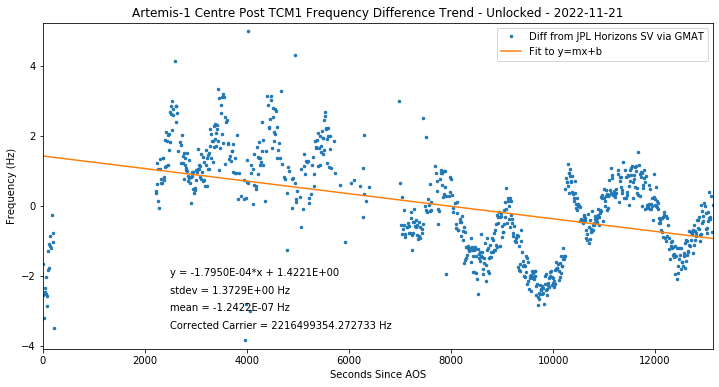

In [9]:
upper = np.max(np_diff)+.25
lower = np.min(np_diff)-.25

plt.ylim(np.mean(np_diff)+lower, np.mean(np_diff)+upper)
plt.xlim(0,max(np_t))
plt.plot(np_t, freq_diff, '.',markersize=5, label = 'Diff from JPL Horizons SV via GMAT')
plt.plot(np_t, m*np_t + b, label = 'Fit to y=mx+b')
plt.text(2500,np.mean(np_diff)-2, 'y = %.4E*x + %.4E'%(m,b))
plt.text(2500,np.mean(np_diff)-2.5, 'stdev = %.4E Hz'%np.std(np_diff))
plt.text(2500,np.mean(np_diff)-3, 'mean = %.4E Hz'%np.mean(np_diff))
plt.text(2500,np.mean(np_diff)-3.5, 'Corrected Carrier = %.6f Hz'%corrected_carrier)
plt.title('Artemis-1 Centre Post TCM1 Frequency Difference Trend - Unlocked - %s'%(t_data.datetime[0].strftime('%Y-%m-%d')))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Seconds Since AOS')
plt.legend()
plt.show();


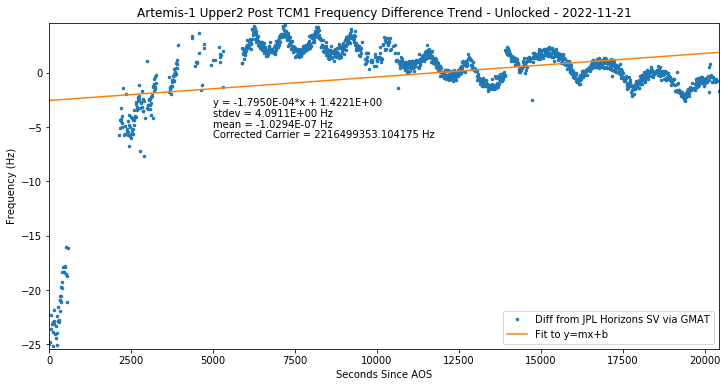

In [10]:
upper = np.max(np_diff2)+.25
lower = np.min(np_diff2)-.25

plt.ylim(np.mean(np_diff2)+lower, np.mean(np_diff)+upper)
plt.xlim(0,max(np_t2))
plt.plot(np_t2, freq_diff2, '.',markersize=5, label = 'Diff from JPL Horizons SV via GMAT')
plt.plot(np_t2, m2*np_t2 + b2, label = 'Fit to y=mx+b')
plt.text(5000,np.mean(np_diff2)-3, 'y = %.4E*x + %.4E'%(m,b))
plt.text(5000,np.mean(np_diff2)-4, 'stdev = %.4E Hz'%np.std(np_diff2))
plt.text(5000,np.mean(np_diff2)-5, 'mean = %.4E Hz'%np.mean(np_diff2))
plt.text(5000,np.mean(np_diff2)-6, 'Corrected Carrier = %.6f Hz'%corrected_carrier2)
plt.title('Artemis-1 Upper2 Post TCM1 Frequency Difference Trend - Unlocked - %s'%(t_data.datetime[0].strftime('%Y-%m-%d')))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Seconds Since AOS')
plt.legend()
plt.show();

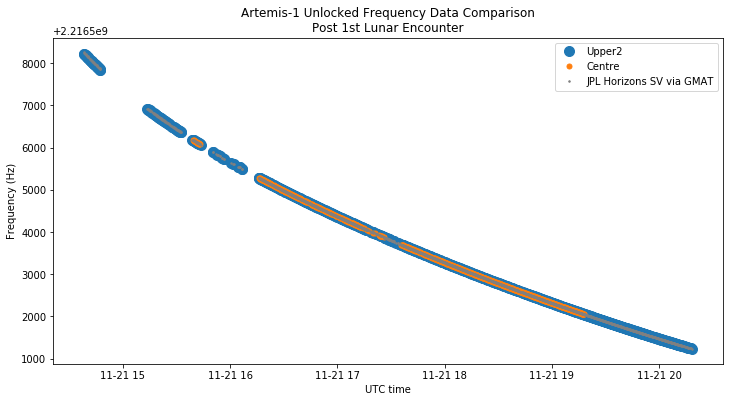

In [11]:
plt.plot(t_data2.datetime,freq_data2,'.' ,markersize=20, alpha=2, label = 'Upper2')
plt.plot(t_data.datetime,freq_data,'.' ,markersize=10, alpha=2, label = 'Centre')
plt.plot(t_data2.datetime, freq_gmat2, '.',markersize=3,alpha=1,label = 'JPL Horizons SV via GMAT', color='grey')
plt.title('Artemis-1 Unlocked Frequency Data Comparison\nPost 1st Lunar Encounter')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.legend()
plt.show();

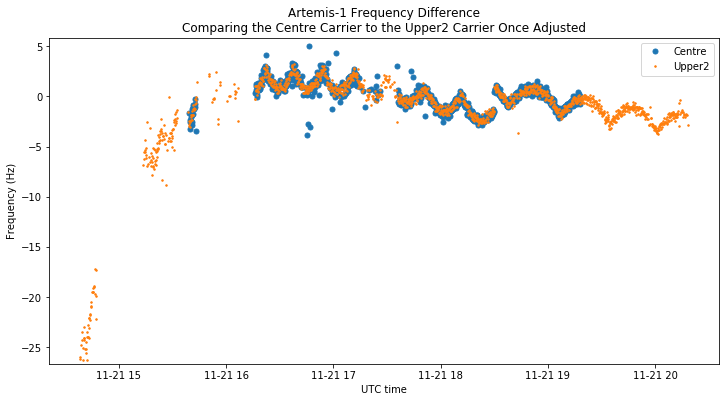

In [12]:
plt.ylim(np.min(np_diff2)-1.5, np.max(np_diff2)+1.5)
plt.plot(t_data.datetime, freq_data - freq_gmat,'.', markersize=10, label = 'Centre')
plt.plot(t_data2.datetime, (freq_data2 - freq_gmat2)-(corrected_carrier-corrected_carrier2),'.', markersize=3, label = 'Upper2')
plt.title('Artemis-1 Frequency Difference\nComparing the Centre Carrier to the Upper2 Carrier Once Adjusted')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.legend()
plt.show()

In [13]:
#Difference in Centre to Lower2 carriers
print(corrected_carrier-corrected_carrier2)

print(corrected_carrier - f_carrier_20221119)

1.1685576438903809
180.83506631851196


In [14]:
45.45442960526

45.45442960526